# Imports

In [2]:
import numpy as np
import librosa 
from os import environ
environ["MEDLEYDB_PATH"] = "/Datasets/MedleyDB"
import medleydb as mdb
import sklearn
import os
import sox
import tempfile as tmp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier

# Getting list of multitracks without bleed

In [3]:
loader = mdb.load_all_multitracks()
no_bleed_mtracks = []
for mtrack in loader:
    print mtrack.track_id
    if not mtrack.has_bleed:
        no_bleed_mtracks.append(mtrack)

AClassicEducation_NightOwl
AimeeNorwich_Child
AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
AmarLal_SpringDay1
Auctioneer_OurFutureFaces
AvaLuna_Waterduct
BigTroubles_Phantom
BrandonWebster_DontHearAThing
BrandonWebster_YesSirICanFly
CelestialShore_DieForUs
ChrisJacoby_BoothShotLincoln
ChrisJacoby_PigsFoot
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Boys
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_TheBadGuys
ClaraBerryAndWooldog_WaltzForMyVictims
Creepoid_OldTree
CroqueMadame_Oil
CroqueMadame_Pilot
Debussy_LenfantProdigue
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_BluesForNofi
EthanHein_GirlOnABridge
EthanHein_HarmonicaFigure
FacesOnFilm_WaitingForGa
FamilyBand_Again
Grants_PunchDrunk
Handel_TornamiAVagheggiar
HeladoNegro_MitadDelMundo
HezekiahJones_BorrowedHeart
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
JoelHelander_Definition
JoelHelander_ExcessiveResistancetoChange
JoelHelander

# Get instrument labels

In [4]:
#list of all possible instrument labels
valid_labels = mdb.multitrack.get_valid_instrument_labels()

# Loop over instrument to get files

In [5]:
file_dict = {}
#dictionary of list of labels for every multitrack without bleed

for label in valid_labels:
    label_list = list(mdb.utils.get_files_for_instrument(label, multitrack_list = no_bleed_mtracks))
    #list of labels of multitracks with no bleed
    
    if len(label_list) == 0:
        continue
    file_dict[label] = label_list


# Compute MFCC

In [ ]:
mfcc_list = []
label_list = []
mfcc_dict = {}
label_index = 0

# loop over instrument labels
for label in list(file_dict.keys()):
    print label
    print len(file_dict[label])
    
    folder_name = "instrument_mfcc"
    instrument_file = os.path.join(folder_name,"%s.npy" % label)
    label_file = os.path.join(folder_name,"%s-label.npy" % label)
    
    if os.path.exists(instrument_file) and os.path.exists(label_file):
        print "loading existing file..."
        instrument_mfcc_list = np.load(instrument_file) 
        instrument_label_list = np.load(label_file)
        
        print instrument_mfcc_list.shape
        print instrument_label_list.shape
        
    else:
        print "creating new file..."
        instrument_mfcc_list = []
        instrument_label_list = []

        # loop over files for instruments
        for fpath in file_dict[label]:
            print fpath
            # normalizing volume, removing silence
            temp_fpath = tmp.NamedTemporaryFile(suffix=".wav")
            tfm = sox.Transformer()
            tfm.norm(db_level=-6)
            tfm.silence()
            tfm.build(fpath, temp_fpath.name)

            # load audio
            y, fs = librosa.load(temp_fpath.name)

            # compute MFCCs
            M = librosa.feature.mfcc(y, sr=fs, n_mfcc=40)

            lab = np.zeros((len(M[0]), )) + label_index
            instrument_mfcc_list.append(M)
            instrument_label_list.append(lab)
        
        save_instrument_mfcc = np.hstack(instrument_mfcc_list)
        print save_instrument_mfcc.shape
        np.save(instrument_file, save_instrument_mfcc)
        
        save_instrument_label = np.hstack(instrument_label_list)      
        np.save(label_file, save_instrument_label)
            
    # creating labels
    mfcc_list.append(save_instrument_mfcc)
    label_list.append(save_instrument_label)
        
    print ""
    label_index = label_index + 1

In [30]:
mfcc_list
print (len(mfcc_list))
print (mfcc_list[0].shape)
print (mfcc_list[-1].shape)

14
(40, 9167)
(40, 5402)


In [31]:
mfcc_matrix = np.hstack(mfcc_list).T
label_matrix = np.hstack(label_list)

In [32]:
np.save("mfcc_matrix.npy", mfcc_matrix)
np.save("label_matrix.npy", label_matrix)

# Standardizing MFCC Matrix

In [33]:
mfcc_means = np.mean(mfcc_matrix, axis = 0)
mfcc_std = np.std(mfcc_matrix, axis=0)

np.save("mfcc_means.npy", mfcc_means)
np.save("mfcc_std.npy", mfcc_std)

mfcc_matrix_normal = (mfcc_matrix - mfcc_means)/mfcc_std

label_values = list(file_dict.keys())
np.save("label_values.npy", label_values)

# Plot MFCC Data Matrix

In [51]:
mfcc_matrix[start_index:end_index, :]

array([[ -4.16020838e+02,   6.39514519e+01,   1.81778682e+01, ...,
          1.19739278e+00,   8.81296362e-01,  -1.39744568e+00],
       [ -3.29753821e+02,   9.54040063e+01,   3.07943181e+01, ...,
          4.84301480e-01,  -2.29102191e-01,  -2.04127913e-01],
       [ -2.35951682e+02,   9.55522165e+01,   2.86725574e+01, ...,
         -3.92461014e+00,  -2.05954206e+00,  -2.25663136e+00],
       ..., 
       [ -4.92879648e+02,   9.15934447e+01,   2.13688107e+01, ...,
          4.09223777e+00,  -6.57717942e-01,  -4.93516824e+00],
       [ -4.89188107e+02,   9.17733516e+01,   2.50114069e+01, ...,
          2.97039331e-01,  -9.89679128e-01,  -5.44499887e+00],
       [ -3.22057268e+02,   1.42318298e+02,   4.71001206e+00, ...,
         -1.77820049e+00,  -6.01940507e-01,   2.94238269e+00]])

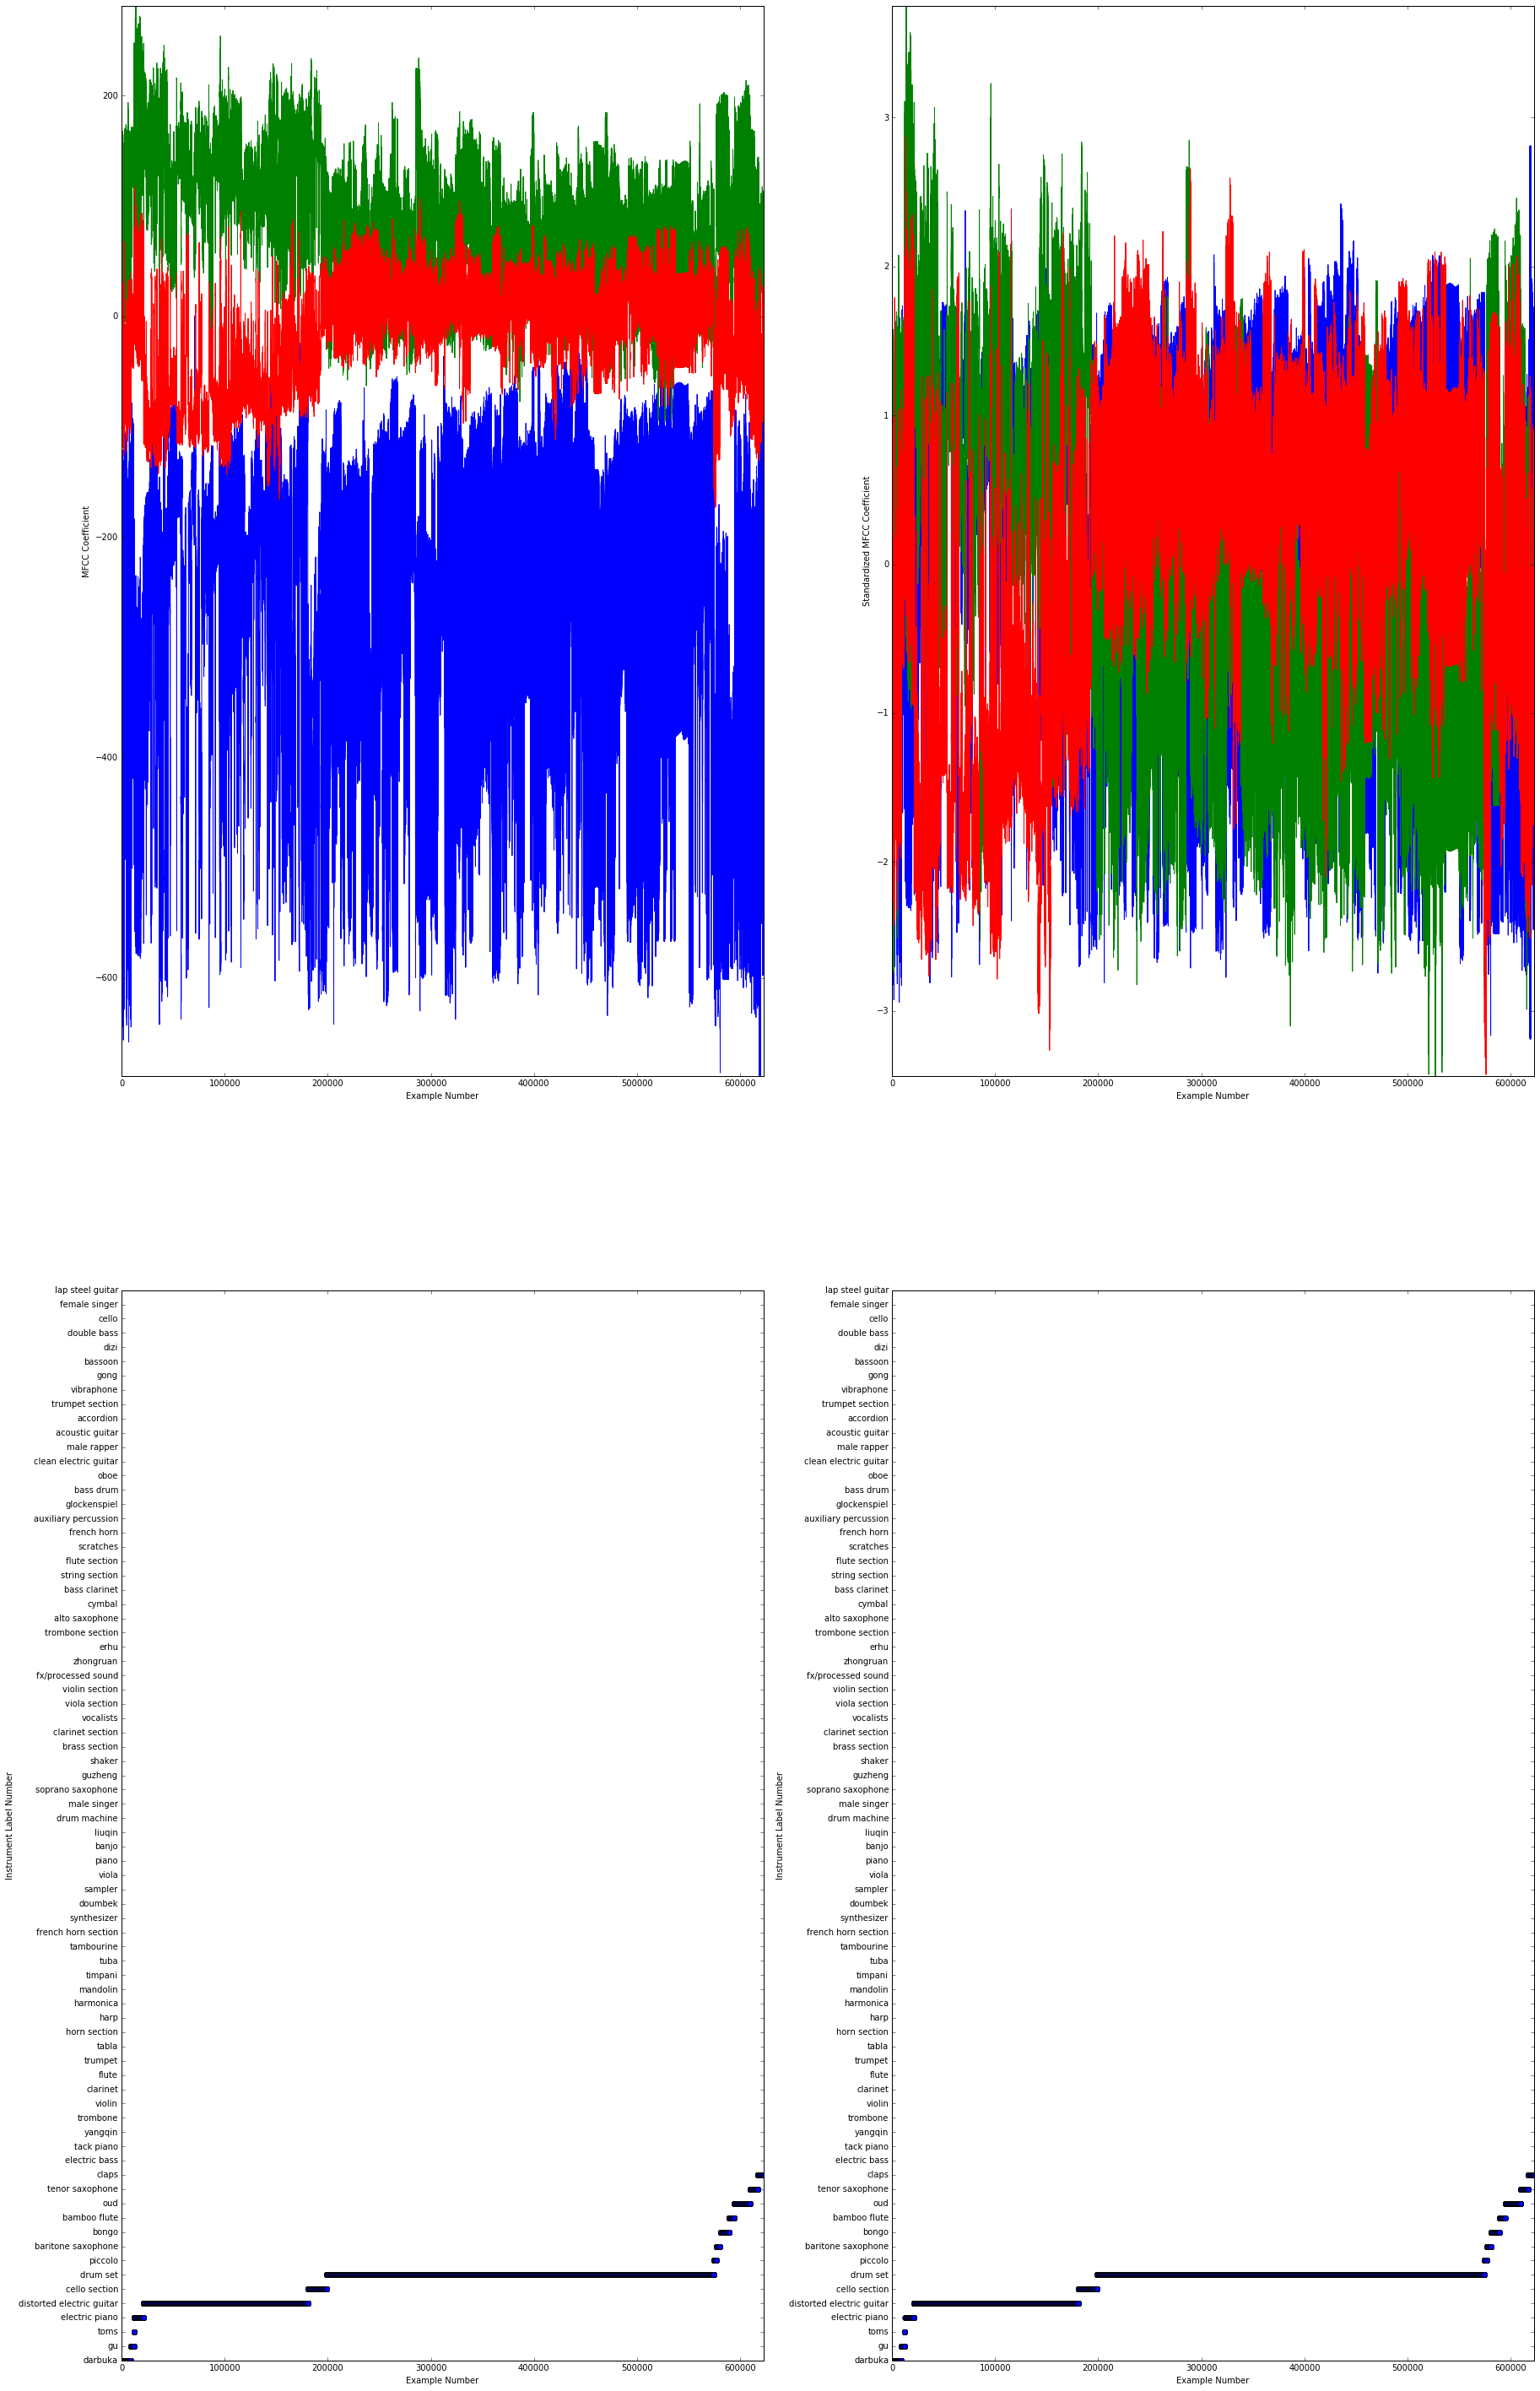

In [59]:
label_index_list = np.arange(len(label_values))
plt.figure(figsize = (30, 50))

start_index=0
end_index=-1

plt.subplot(2,2,1)
# plt.imshow(mfcc_matrix[start_index:end_index, 0:2].T, origin = "lower", interpolation='none')
plt.plot(mfcc_matrix[:, 0])
plt.plot(mfcc_matrix[:, 1])
plt.plot(mfcc_matrix[:, 2])
# plt.colorbar()
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("MFCC Coefficient")

plt.subplot(2,2,3)
plt.plot(label_matrix[start_index:end_index], "o")
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Instrument Label Number")
plt.yticks(label_index_list, label_values, rotation='horizontal')

plt.subplot(2,2,2)
# plt.imshow(mfcc_matrix_normal[start_index:end_index, 0:2].T, origin = "lower", interpolation='none')
# plt.colorbar()
plt.plot(mfcc_matrix_normal[:, 0])
plt.plot(mfcc_matrix_normal[:, 1])
plt.plot(mfcc_matrix_normal[:, 2])
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Standardized MFCC Coefficient")

plt.subplot(2,2,4)
plt.plot(label_matrix[start_index:end_index], "o")
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Instrument Label Number")
plt.yticks(label_index_list, label_values, rotation='horizontal')

plt.show()

In [25]:
clf = RandomForestClassifier(n_estimators = 10)
clf.fit(mfcc_matrix_normal, label_matrix)

from sklearn.externals import joblib
joblib.dump(clf, "instrument_classifer.pkl")


['instrument_classifer.pkl']

In [26]:
clf.score(mfcc_matrix_normal, label_matrix)

1.0

In [27]:
def clf_predict(audio_fpath, clf, mfcc_means, mfcc_std):
    # normalizing volume, removing silence
    temp_fpath = tmp.NamedTemporaryFile(suffix=".wav")
    tfm = sox.Transformer()
    tfm.norm(db_level=-6)
    tfm.silence()
    tfm.build(audio_fpath, temp_fpath.name)
        
    # load audio
    y, fs = librosa.load(temp_fpath.name)
        
    # compute MFCCs
    M = librosa.feature.mfcc(y, sr=fs, n_mfcc=40)
    
    M_normal = (M - mfcc_means)/mfcc_std
    
    predicted_label = clf.predict(M_normal.T)
    